# Visualize Type Sizes

An overcomplicated method of generating what turned out to be very boring pictures of rust type memory layout and alignment.

In [12]:
from collections import defaultdict
import subprocess
import os
from typing import Literal
from pathlib import Path
import tomllib

from IPython.display import SVG
import pandas as pd

from μsvg import (
    Rect,
    Vec2,
    Node,
    Attr
)

In [13]:
crate_to_compile = Path("../wintab_lite/")
assert(crate_to_compile.is_dir())
assert((crate_to_compile / "Cargo.toml").exists())

output_location = Path("./output/")
output_location.mkdir(exist_ok=True)
(output_location / ".gitignore").write_text("*")

1

In [14]:
# Cargo does not run rustc if nothing changed;
# we need to perform a clean to force recompilation on every run
print("Cleaning...")
try:
    completed_process = subprocess.run(
        args=[
            "cargo",
            "clean",
            "--package", tomllib.loads((crate_to_compile / "Cargo.toml").read_text())["package"]["name"],
            "--release"
        ],
        cwd=crate_to_compile,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
except subprocess.CalledProcessError as e:
    print(e)
print(completed_process.stderr.decode())

print("Compiling...")
try:
    completed_process = subprocess.run(
        args   = [
            "cargo", 
            "+nightly",
            "build",
            "--release",
        ],
        cwd    = crate_to_compile,
        env    = os.environ | {
            "RUSTFLAGS":"-Z print-type-sizes"
        },
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
    )
except subprocess.CalledProcessError as e:
    print(e)

print(completed_process.stderr.decode())

Cleaning...
     Removed 10 files, 3.7MiB total

Compiling...
   Compiling wintab_lite v0.1.0 (M:\GIT\get_pen_pressure_test\wintab_lite)
 --> wintab_lite\src\coordinate.rs:1:16
  |
1 | use std::fmt::{write, Debug};
  |                ^^^^^
  |
  = note: `#[warn(unused_imports)]` on by default

 --> wintab_lite\src\wrapper.rs:3:18
  |
3 | use libloading::{Library, Symbol};
  |                  ^^^^^^^

  --> wintab_lite\src\c_type_aliases.rs:50:8
   |
43 | impl FIX32 {
   | ---------- methods in this implementation
...
50 |     fn int_part(self) -> c_uint {
   |        ^^^^^^^^
...
55 |     fn frac_part(self) -> c_uint {
   |        ^^^^^^^^^
   |
   = note: `#[warn(dead_code)]` on by default

 --> wintab_lite\src\wrapper.rs:7:12
  |
7 | pub struct Wrapper<'a, T> {
  |            ^^^^^^^

  --> wintab_lite\src\log_context.rs:21:9
   |
21 |     pub lcName: CString40,
   |         ^^^^^^ help: convert the identifier to snake case: `lc_name`
   |
   = note: `#[warn(non_snake_case)]` on by 

In [15]:
df = pd.Series(completed_process.stdout.decode('utf-8').splitlines()).convert_dtypes()
df = df[df.str.startswith("print-type-size")]
df = (
    df
    .str.removeprefix("print-type-size")
    .str.strip()
    .rename("lines")
)
df = df.str.extract(r"(.*?)( `[^`]*`)?: (\d+) bytes(, alignment: (\d+) bytes)?")
df = df.rename(columns={0: "item", 1:"field_name", 2:"size", 3:"junk", 4:"alignment"})
df = df.drop(columns="junk")
df["size"] = pd.to_numeric(df["size"])
df["alignment"] = pd.to_numeric(df["alignment"])
df["item"] = df["item"].str.strip(":")
df["field_name"] = df["field_name"].str.strip(" `.")
types = df[df["item"]=="type"]
df = df.join(types["field_name"].rename("type_name"))
df["type_name"] = df["type_name"].ffill()
df = df.drop(types.index).reset_index(drop=True)
types = types.rename(columns={"field_name": "type_name"})
types = types.reset_index(drop=True).set_index("type_name").drop(columns="item")
new_chunks = []
for group_index, group_frame in df.groupby("type_name"):
    group_frame["order"] = pd.RangeIndex(len(group_frame))
    #group_frame = group_frame.set_index(["type_name","order"])
    new_chunks.append(group_frame)
df = pd.concat(new_chunks)
df = df.join(types["alignment"].rename("type_alignment"), on="type_name")
df = df.set_index(["type_name","type_alignment", "order"])

In [16]:
sample_types = types[~types.index.str.startswith(("std::", "core::", "alloc", "{closure", "os::"))].sample(10)
sample_types

,size,alignment
type_name,,
information_categories::DVC,4,4
bitflags::iter::IterNames<information_categories::HWC>,32,8
coordinate::XYZ<c_type_aliases::FIX32>,12,4
bitflags::iter::IterNames<log_context::CXO>,32,8
axis::TU,4,4
packet::TPS,4,4
bitflags::Flag<packet::TPS>,24,8
bitflags::parser::ParseErrorKind,1,1
bitflags::__private::core::fmt::rt::Alignment,1,1


In [17]:
df.loc[sample_types.index]

item  \
type_name                                          type_alignment order                 
information_categories::DVC                        4              0      discriminant   
                                                                  1           variant   
                                                                  2           variant   
                                                                  3           variant   
                                                                  4           variant   
                                                                  5           variant   
                                                                  6           variant   
                                                                  7           variant   
                                                                  8           variant   
                                                                  9           variant   
                                                                  10          variant   
                                                                  11          variant   
                                                                  12          variant   
                                                                  13          variant   
                                                                  14          variant   
                                                                  15          variant   
                                                                  16          variant   
                                                                  17          variant   
                                                                  18          variant   
                                                                  19          variant   
bitflags::iter::IterNames<information_categorie... 8              0             field   
                                                                  1             field   
                                                                  2             field   
                                                                  3             field   
coordinate::XYZ<c_type_aliases::FIX32>             4              0             field   
                                                                  1             field   
                                                                  2             field   
bitflags::iter::IterNames<log_context::CXO>        8              0             field   
                                                                  1             field   
                                                                  2             field   
                                                                  3             field   
axis::TU                                           4              0      discriminant   
                                                                  1           variant   
                                                                  2           variant   
                                                                  3           variant   
                                                                  4           variant   
packet::TPS                                        4              0             field   
bitflags::Flag<packet::TPS>                        8              0             field   
                                                                  1             field   
                                                                  2       end padding   
bitflags::parser::ParseErrorKind                   1              0      discriminant   
                                                                  1           variant   
                                                                  2           variant   
                                                                  3         

In [46]:
types_to_plot = [
    "log_context::LOGCONTEXT",
    "packet::Packet",
    "axis::AXIS",
]

In [47]:
data_to_plot = df.loc[types_to_plot]

groups = data_to_plot.groupby(["type_name","type_alignment"])
max_value = groups["size"].sum().max()

CHART_SIZE_X              : float = 800
CHART_SIZE_Y              : float = 400
CHART_PADDING             : float = 5
CHART_GROUP_HEADING_SPACE : float = 120
LAYOUT                    : Literal["horizontal", "vertical"] = "horizontal"

if LAYOUT=="horizontal":
    axis_data  = Vec2(1, 0)
    axis_group = Vec2(0, 1)
else:
    axis_data  = Vec2(0, 1)
    axis_group = Vec2(1, 0)

bar_padding = axis_data * 2 + axis_group * 5

chart_rect          = Rect.from_top_left_size(Vec2(0,0), Vec2(CHART_SIZE_X, CHART_SIZE_Y))
chart_padding       = Vec2(1, 1) * CHART_PADDING
chart_title_padding = axis_data * CHART_GROUP_HEADING_SPACE
count_bars          = axis_data + axis_group * len(groups)
axes_rect           = Rect(chart_padding, chart_rect.size() - chart_padding)
axes_rect           = axes_rect.crop_top_left(chart_title_padding)
scale               = axis_group + axis_data * axes_rect.size() / max_value
bar_size            = axes_rect.size() / count_bars * (axis_data + axis_group * 0.8)
bar_spacing         = axes_rect.size() / count_bars 
remaining_space     = axes_rect.size() - count_bars * bar_size
first_bar_offset    = remaining_space / count_bars / 2

In [60]:
class dracula:
    background   = "#282a36"
    current_line = "#44475a"
    foreground   = "#f8f8f2"
    comment      = "#6272a4"
    cyan         = "#8be9fd"
    green        = "#50fa7b"
    orange       = "#ffb86c"
    pink         = "#ff79c6"
    purple       = "#bd93f9"
    red          = "#ff5555"
    yellow       = "#f1fa8c"


styles = defaultdict(lambda: {
    "stroke" : dracula.comment,
    "fill"   : dracula.current_line,
    "stroke-width" : "2",
})

styles["discriminant"] = {
    "fill"   : dracula.cyan,
}

styles["end padding"] = {
    "fill"   : dracula.pink,
}

styles["padding"] = {
    "fill"   : dracula.red,
}
styles["variant"] ={
    "fill"   : dracula.green,
}

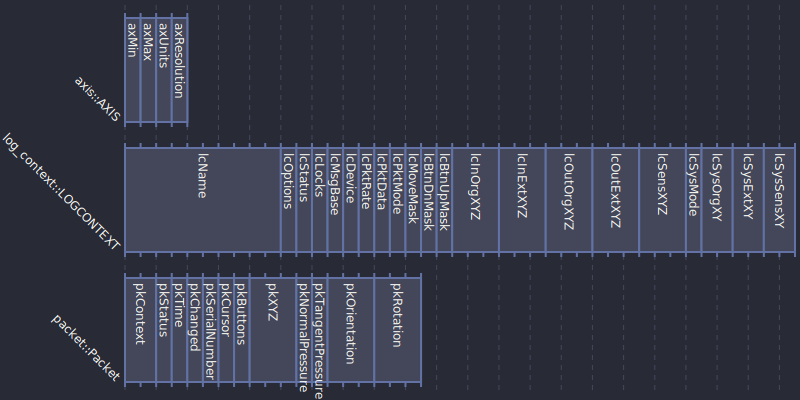

In [61]:
content = []

for group_index, ((group_name, group_alignment), group) in enumerate(groups):
    # fill field_name na with blank
    group["field_name"] = group["field_name"].fillna("")
    group_position = group_index * bar_spacing * axis_group + first_bar_offset

    bar_rect_content = []
    bar_line_content = []
    bar_text_content = []

    bar_text_position = bar_size * axis_group
    bar_text_content.append(
        Node(
            tag_name = "text",
            body     = [group_name],
            attr     = Attr(
                fill        = dracula.foreground,
                font_size   = 12,
                transform   = f"translate({(bar_text_position-axis_data*10).svg()}) rotate(45)",
                text_anchor = "end",
            )
        )
    )

    bar_offset = Vec2(0, 0)

    for index, row in group.iterrows():
        item_size = bar_size * axis_group + row["size"] * axis_data * scale
        #label_position = axis_data * (bar_offset + item_size / 2) + bar_offset * axis_group
        bar_rect = Rect.from_top_left_size(bar_offset, item_size)

        if row["size"] == 0:
            # zero size entry
            bar_line_content.append(
                Node(
                    tag_name = "line",
                    attr     = Attr(
                        x1           = bar_rect.top_left.x,
                        y1           = bar_rect.top_left.y,
                        x2           = bar_rect.bottom_right.x,
                        y2           = bar_rect.bottom_right.y,
                        stroke       = dracula.foreground,
                        stroke_width = 2,
                    )
                )
            )
            text_location = bar_rect.bottom_right# * axis_group + bar_rect.size() * axis_data
            text_baseline = "hanging"
            text_halign   = "end"
        else:
            style_default = styles["default"]
            style_lookup = styles[row["item"]]
            bar_rect_content.append(
                Node(
                    tag_name = "rect",
                    attr     = Attr(
                        x            = bar_rect.top_left.x,
                        y            = bar_rect.top_left.y,
                        width        = bar_rect.width(),
                        height       = bar_rect.height(),
                        **(style_default | style_lookup),
                    )
                )
            )
            bar_rect_cropped = bar_rect.crop(bar_padding)
            text_location = bar_rect_cropped.top_left + axis_data * bar_rect_cropped.size() / 2
            text_baseline = "middle"
            text_halign   = "start"

        bar_text_content.append(
            Node(
                tag_name= "text",
                body=[row["field_name"]],
                attr=Attr(
                    fill      = dracula.foreground,
                    font_size = 12,
                    dominant_baseline = text_baseline,
                    text_anchor = text_halign,
                    transform = f"translate({text_location.svg()})" + (" rotate(90)" if LAYOUT=="horizontal" else ""),
                )
            )
        )

        bar_offset += item_size*axis_data

    alignment_grid = []
    for i in range(0, group["size"].sum()+group_alignment, group_alignment):
        alignment_line_start = scale * axis_data * i - axis_group*5
        alignment_line_end   = alignment_line_start + bar_size * axis_group + axis_group*10
        alignment_grid.append(
            Node(
                tag_name = "line",
                attr     = Attr(
                    x1           = alignment_line_start.x,
                    y1           = alignment_line_start.y,
                    x2           = alignment_line_end.x,
                    y2           = alignment_line_end.y,
                    stroke       = dracula.comment,
                    stroke_width = 2,
                )
            )
        )

    content.append(
        Node(
            tag_name = "g",
            attr     = Attr(
                id        = f"group_{group_index}",
                transform = f"translate({group_position.svg()})"
            ),
            body=[
                *alignment_grid,
                *bar_rect_content,
                *bar_line_content,
                *bar_text_content,
            ]
        )
    )

grid = []
for i in range(0, max_value, 8):
    grid_line_start = scale * axis_data * i
    grid_line_end   = grid_line_start + axes_rect.size() * axis_group
    grid.append(
        Node(
            tag_name = "line",
            attr     = Attr(
                x1           = grid_line_start.x,
                y1           = grid_line_start.y,
                x2           = grid_line_end.x,
                y2           = grid_line_end.y,
                stroke       = dracula.current_line,
                stroke_width = 1,
                stroke_dasharray = "5,5",
            )
        )
    )

result = Node(
    tag_name="svg",
    attr=Attr(
        width  = chart_rect.width(),
        height = chart_rect.height(),
        xmlns  = "http://www.w3.org/2000/svg",
    ),
    body=[
        Node("rect", attr=Attr(width="100%", height="100%", fill=dracula.background)),
        Node("g",    attr=Attr(id="axes", transform=f"translate({axes_rect.top_left.svg()})"), body=grid),
        Node("g",    attr=Attr(id="axes", transform=f"translate({axes_rect.top_left.svg()})"), body=content)
    ]
).to_string()
(output_location / "output.svg").write_text(result)
SVG(result)

In [62]:
Path("Struct Layout.svg").write_text(result)

25383